Downloading the dataset

In [35]:
# from roboflow import Roboflow 
# #Create object of roboflow 
# rf = Roboflow(api_key = "9HhgLNwnngYzUrANLRyF", model_format="multiclass") 
# dataset = rf.workspace().project("dental_imaging").version(1).download(location="./dental_dataset")

Importing required libraries


In [36]:
import torch
from torch import nn
#base library for PyTorch computervision  
import torchvision 
from torchvision.transforms import ToTensor 




Creating dataset

In [37]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image


class dentalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        csv_path = os.path.join(root_dir, "_classes.csv")
        self.df = pd.read_csv(csv_path)

        #filenames
        self.image_names = self.df.iloc[:, 0].values

        #class names from column
        self.class_names = list(self.df.columns[1:])

        #class index
        self.labels = self.df.iloc[:, 1:].values.argmax(axis=1)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


Checking access to GPU, Setting GPU for computation


In [38]:
import torch 
torch.cuda.is_available() 

device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Transforming dataset 

In [39]:
from torchvision import transforms

basicTransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

Transforming train test and validation datasets

In [40]:
train_data = dentalDataset(root_dir="dental_dataset/train",transform = basicTransform )

test_data = dentalDataset(root_dir="dental_dataset/test",transform=basicTransform)

validation_data = dentalDataset(root_dir="dental_dataset/valid",transform = basicTransform)



Creating Dataloaders

In [41]:
from torch.utils.data import DataLoader
#setting up batch size 
BATCH_SIZE = 16

#shuffling data every epoch
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)
val_dataloader = DataLoader(dataset = validation_data, batch_size = BATCH_SIZE, shuffle = True)


Information of dataloaders

In [42]:
print(f"Dataloaders: {train_dataloader, test_dataloader, val_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000266759A89E0>, <torch.utils.data.dataloader.DataLoader object at 0x00000266759A8D10>, <torch.utils.data.dataloader.DataLoader object at 0x0000026677BB4C50>)
Length of train dataloader: 306 batches of 16
Length of validation dataloader: 44 batches of 16
Length of test dataloader: 39 batches of 16


Viewing classes and their information 

In [43]:

import pandas as pd
class_names = train_data.class_names
print(f"The classes present in the dataset are: {class_names}\n")

class_list = pd.Series(class_names).value_counts() 
print("The number of each class in the data are:")
print(class_list)

The classes present in the dataset are: ['caries', 'cavity', 'gingivitis', 'gum_swelling', 'healthy', 'plaque']

The number of each class in the data are:
caries          1
cavity          1
gingivitis      1
gum_swelling    1
healthy         1
plaque          1
Name: count, dtype: int64


In [44]:
#Viewing contents of train dataloader 
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape)
print(train_labels_batch.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


Tensor shape: torch.Size([3, 224, 224])
Label index: 0
Class name: caries


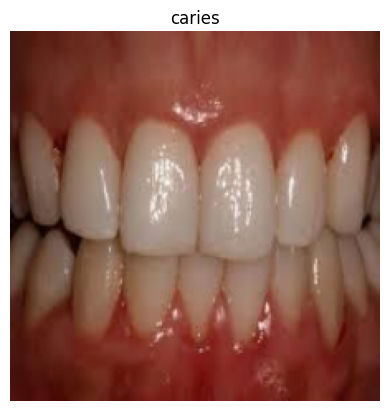

In [45]:
#viewing a sample
import torch
import matplotlib.pyplot as plt

#Getting a random sample from the batch
random_idx = torch.randint(
    low=0,
    high=train_features_batch.size(0),
    size=(1,)
).item()

#Extracting image and label
img = train_features_batch[random_idx]      
label = train_labels_batch[random_idx]      


#Converting to H,W,C for matplotlib
img_vis = img.permute(1, 2, 0)

plt.imshow(img_vis)
plt.title(class_names[int(label)])
plt.axis("off")

# Debug / verification prints
print(f"Tensor shape: {img.shape}")      
print(f"Label index: {int(label)}")
print(f"Class name: {class_names[int(label)]}")



Creating the Convolutional Neural Network

In [46]:

class DentalDatasetCNN(nn.Module):
    """CNN for carrying out dental classification"""
    #initalizing our class 
    def __init__(self):
        #initalizing our initailizer,real
        super().__init__()
        #creating in blocks [convolutional block]
        self.conv_block_1 = nn.Sequential(
            #conv2d because we are working with 2 dimensional data
            nn.Conv2d(3,
                      100,
                      kernel_size =3,
                      stride =1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride =1) 
              
        )
        #Classifying into target classes, classifier layer
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features = 100, out_features = 6)
        )
        
    def forward(self,x):
        x= self.conv_block_1(x)
        x= self.classifier(x)
        return x
        

Creating instance of CNN model

In [47]:
#torch.manual_seed(42)
CNNmodel = DentalDatasetCNN(
    #input_shape = 3,
    #hidden_units =6,
    #output_shape = len(class_names)
).to(device)

print(len(class_names))

6


Setting up timer to time the experiment

In [48]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Print difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

setting up loss function, optimizer and evaluation metrics

In [49]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() #torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

lossFunction = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params = CNNmodel.parameters(), lr = 1e-1)

#function for calculating precision, recall and f1score
def precision_recall_f1(y_pred, y_true, classes = 6):
    precisionList = [] 
    recallList = [] 
    f1List = []

    for cls in range(classes):
        TP = ((y_pred == cls) & (y_true == cls)).sum().item()
        FP = ((y_pred == cls) & (y_true != cls)).sum().item()
        FN = ((y_pred !=cls) & (y_true == cls)).sum().item()

        precision = TP/(TP+FP) if (TP+FP) >0 else 0.0
        recall = TP/(TP+FN) if (TP + FN) >0 else 0.0
        f1_score = 2*((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0.0
    
        precisionList.append(precision)
        recallList.append(recall)
        f1List.append(f1_score)
        
    precision = sum(precisionList) /classes
    recall = sum(recallList) / classes
    f1 = sum(f1List)/classes

    return precision,recall,f1

Creating training and testing loops

In [50]:
#Function for training model 
"""Things needed: 
model, dataloader, 
model, optimizer, 
accuracy function""" 

def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs training step of model"""
    train_loss, train_accuracy = 0,0
    train_preds, train_labels = [],[]

    #setting model to training mode 
    model.train()

    #looping through the training batches 
    for batch,(X,y) in enumerate(data_loader):
        #set data in taget device
        X,y = X.to(device), y.to(device)

        #conduct forward pass 
        y_pred = model(X)

        #accuracy and loss calculation per batch
        loss = lossFunction(y_pred,y)
        train_loss += loss.item()
        train_accuracy += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1)) #logits to prediction labels
        optimizer.zero_grad()
        loss.backward() 
        #optimize model's parameter once per batch
        optimizer.step()
    
        train_preds.append(y_pred.argmax(dim=1))
        train_labels.append(y)

    train_preds = torch.cat(train_preds)
    train_labels = torch.cat(train_labels)

    precision,recall,f1 = precision_recall_f1(train_labels,train_preds)

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)


    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}% | Precision:{precision:.4f} | Recall :{recall:.4f} | f1-score: {f1:.4f}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs test step of the model"""
    test_loss, test_accuracy = 0, 0
    predictions, labels = [],[]
    model.to(device)
    #Set model to evaluation mode
    model.eval() 
    #Turn on inference context manager
    with torch.inference_mode():
        #image,label 
        for X, y in data_loader:
            #Send data to GPU
            X, y = X.to(device), y.to(device)
            
            #Perform forward pass
            test_pred = model(X)
            
            
            #Calculate testing loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_accuracy += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) 
            )

            predictions.append(test_pred.argmax(dim=1))
            labels.append(y)

        predictions = torch.cat(predictions)
        labels = torch.cat(labels)

        precision, recall, f1 = precision_recall_f1(labels, predictions)
        test_loss /= len(data_loader)
        test_accuracy /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}% | Precision:{precision:.4f} | Recall :{recall:.4f} | f1-score: {f1:.4f}")

Training our model

In [51]:
from tqdm import tqdm
#Measuring time 
from timeit import default_timer as timer 
train_time_start = timer() 
 
#Train and test model 
epochs = 6 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---")
    train_step(model=CNNmodel, 
               data_loader=train_dataloader,
               loss_fn=lossFunction, 
               optimizer = optimizer, 
               accuracy_fn = accuracy_fn, 
               device = device)
    test_step(model = CNNmodel, 
              data_loader = 
              test_dataloader, 
              loss_fn=lossFunction,
              accuracy_fn = accuracy_fn, 
              device = device)

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, 
                                    end=train_time_end, device = device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---
Train loss: 1.61615 | Train accuracy: 38.01% | Precision:0.1653 | Recall :0.1115 | f1-score: 0.1015


 17%|█▋        | 1/6 [00:14<01:13, 14.77s/it]

Test loss: 1.67371 | Test accuracy: 25.94% | Precision:0.1667 | Recall :0.0428 | f1-score: 0.0681
Epoch: 1
---
Train loss: 1.57281 | Train accuracy: 38.54% | Precision:0.1656 | Recall :0.1024 | f1-score: 0.0995


 33%|███▎      | 2/6 [00:30<01:01, 15.41s/it]

Test loss: 1.69756 | Test accuracy: 25.94% | Precision:0.1667 | Recall :0.0428 | f1-score: 0.0681
Epoch: 2
---
Train loss: 1.57142 | Train accuracy: 39.11% | Precision:0.1667 | Recall :0.0649 | f1-score: 0.0934


 50%|█████     | 3/6 [00:45<00:45, 15.12s/it]

Test loss: 1.69110 | Test accuracy: 25.94% | Precision:0.1667 | Recall :0.0428 | f1-score: 0.0681
Epoch: 3
---
Train loss: 1.57317 | Train accuracy: 38.85% | Precision:0.1660 | Recall :0.0995 | f1-score: 0.0956


 67%|██████▋   | 4/6 [01:01<00:31, 15.51s/it]

Test loss: 1.70876 | Test accuracy: 25.94% | Precision:0.1667 | Recall :0.0428 | f1-score: 0.0681
Epoch: 4
---
Train loss: 1.57719 | Train accuracy: 38.50% | Precision:0.1671 | Recall :0.1104 | f1-score: 0.1014


 83%|████████▎ | 5/6 [01:16<00:15, 15.29s/it]

Test loss: 1.68928 | Test accuracy: 25.94% | Precision:0.1667 | Recall :0.0428 | f1-score: 0.0681
Epoch: 5
---
Train loss: 1.57711 | Train accuracy: 38.19% | Precision:0.1695 | Recall :0.1105 | f1-score: 0.1149


100%|██████████| 6/6 [01:32<00:00, 15.46s/it]

Test loss: 1.72896 | Test accuracy: 25.94% | Precision:0.1667 | Recall :0.0428 | f1-score: 0.0681
Train time on cuda: 92.763 seconds
